In [1]:
import pandas as pd
import os
import kagglehub

# This downloads and gives you the folder path
path = kagglehub.dataset_download("juniorbueno/pix-banking-transaction")

print("Dataset downloaded to:", path)
csv_path = os.path.join(path, "comprovantes_pix_10000_anomalias.csv")
df = pd.read_csv(csv_path, sep=";")

print(df.head())
print(df.shape)

Dataset downloaded to: /teamspace/studios/this_studio/.cache/kagglehub/datasets/juniorbueno/pix-banking-transaction/versions/1
                             EndToEndId             DataHora    Valor Moeda  \
0  f094cb2c-2a73-463c-b60e-0c57262051e4  2025-06-26 21:07:56  4658.86   BRL   
1  f0409769-741f-49bd-811a-3842cc8f54db  2025-06-23 17:47:56  3184.72   BRL   
2  c1d22287-d343-4c91-b03d-dbe9a69695b3  2025-06-27 15:58:56  1054.48   BRL   
3  254423a9-50b7-41b1-a099-e8cf6232bab4  2025-07-15 13:59:56  3564.76   BRL   
4  f1c5e3e7-bc62-4f18-91e3-c8f92aebdd59  2025-06-23 06:19:56    15.16   BRL   

           Pagador_Nome    Pagador_CPF_CNPJ     Pagador_Banco  \
0        Nathan Cardoso  13.253.967/0001-95       BTG Pactual   
1       Benjamin Barros      781.515.544-64   Banco do Brasil   
2          Lorena Cunha      444.922.709-96       Banco Inter   
3      Sra. Luana Pinto      468.153.904-62       Banco Safra   
4  João Miguel da Cunha  83.407.726/0001-68  Santander Brasil   

       

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
import warnings
warnings.filterwarnings('ignore')


2025-09-04 12:16:47.439574: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 12:16:47.699434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-04 12:16:47.699672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-04 12:16:47.740331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-04 12:16:47.822585: I tensorflow/core/platform/cpu_feature_guar

In [3]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision enabled for better GPU performance")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Mixed precision enabled for better GPU performance


2025-09-04 12:16:54.825984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-04 12:16:55.290541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-04 12:16:55.290790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
X = df.drop(columns=["Anomalia"])
y = df["Anomalia"]

# Identify numerical and categorical columns
numerical_cols = ["Valor"]
categorical_cols = [col for col in X.columns if col not in numerical_cols]

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")


Numerical columns: ['Valor']
Categorical columns: ['EndToEndId', 'DataHora', 'Moeda', 'Pagador_Nome', 'Pagador_CPF_CNPJ', 'Pagador_Banco', 'Recebedor_Nome', 'Recebedor_CPF_CNPJ', 'Recebedor_Banco', 'ChavePix_Utilizada', 'TipoChave', 'Descricao', 'Status']


In [5]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))



TensorFlow: 2.15.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
print("\nProcessing numerical features...")
X_num = X[numerical_cols].copy()

# Log transform for 'Valor' to handle skewness
X_num["Valor_log"] = np.log1p(X_num["Valor"])

# Scale numerical features
scaler_num = StandardScaler()
X_num_scaled = scaler_num.fit_transform(X_num)


Processing numerical features...


In [7]:
print("Processing categorical features...")
categorical_encoded = []

for col in categorical_cols:
    print(f"Encoding {col}: {X[col].nunique()} unique values")
    
    # For high-cardinality categorical variables, use label encoding
    if X[col].nunique() > 50:
        le = LabelEncoder()
        encoded_col = le.fit_transform(X[col].astype(str))
        # Normalize label encoded features
        encoded_col = (encoded_col - encoded_col.mean()) / encoded_col.std()
        categorical_encoded.append(encoded_col.reshape(-1, 1))
    else:
        # For low-cardinality, use one-hot encoding
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
        categorical_encoded.append(dummies.values)


Processing categorical features...
Encoding EndToEndId: 10000 unique values
Encoding DataHora: 9650 unique values
Encoding Moeda: 1 unique values
Encoding Pagador_Nome: 7892 unique values
Encoding Pagador_CPF_CNPJ: 9984 unique values
Encoding Pagador_Banco: 12 unique values
Encoding Recebedor_Nome: 7871 unique values
Encoding Recebedor_CPF_CNPJ: 10000 unique values
Encoding Recebedor_Banco: 13 unique values
Encoding ChavePix_Utilizada: 8863 unique values
Encoding TipoChave: 5 unique values
Encoding Descricao: 1000 unique values
Encoding Status: 3 unique values


In [8]:
if categorical_encoded:
    X_cat_combined = np.hstack(categorical_encoded)
else:
    X_cat_combined = np.array([]).reshape(len(X), 0)

# Combine all features
X_processed = np.hstack([X_num_scaled, X_cat_combined]).astype(np.float32)

In [9]:
print(f"Final processed shape: {X_processed.shape}")
print(f"Memory usage: {X_processed.nbytes / 1024**3:.2f} GB")

Final processed shape: (10000, 39)
Memory usage: 0.00 GB


In [10]:
X_normal = X_processed[y == 0]
X_anomaly = X_processed[y == 1]

print(f"Normal samples: {X_normal.shape[0]}")
print(f"Anomalous samples: {X_anomaly.shape[0]}")

# Further split normal data for training/validation
X_train_normal, X_val_normal = train_test_split(
    X_normal, test_size=0.2, random_state=42
)

print(f"Training normal samples: {X_train_normal.shape[0]}")
print(f"Validation normal samples: {X_val_normal.shape[0]}")


Normal samples: 9900
Anomalous samples: 100
Training normal samples: 7920
Validation normal samples: 1980


In [12]:
def create_advanced_autoencoder(input_dim, encoding_dims=[512, 256, 128, 64, 32]):
    """
    Create a sophisticated autoencoder with skip connections and batch normalization
    """
    
    # Input
    input_layer = layers.Input(shape=(input_dim,), name='input')
    
    # Encoder with skip connections
    x = input_layer
    skip_connections = []
    
    for i, dim in enumerate(encoding_dims):
        x = layers.Dense(dim, name=f'encoder_dense_{i}')(x)
        x = layers.BatchNormalization(name=f'encoder_bn_{i}')(x)
        x = layers.Activation('relu', name=f'encoder_relu_{i}')(x)
        x = layers.Dropout(0.1, name=f'encoder_dropout_{i}')(x)
        
        # Store skip connections (except for the bottleneck)
        if i < len(encoding_dims) - 1:
            skip_connections.append(x)
    
    # Bottleneck (latent representation)
    latent = x
    
    # Decoder with skip connections
    x = latent
    for i, dim in enumerate(reversed(encoding_dims[:-1])):
        x = layers.Dense(dim, name=f'decoder_dense_{i}')(x)
        x = layers.BatchNormalization(name=f'decoder_bn_{i}')(x)
        x = layers.Activation('relu', name=f'decoder_relu_{i}')(x)
        
        # Add skip connection
        if i < len(skip_connections):
            skip = skip_connections[-(i+1)]
            x = layers.Add(name=f'decoder_skip_{i}')([x, skip])
        
        x = layers.Dropout(0.1, name=f'decoder_dropout_{i}')(x)
    
    # Output layer
    output = layers.Dense(input_dim, activation='linear', 
                         dtype='float32', name='output')(x)

    autoencoder = models.Model(input_layer, output, name='AdvancedAutoencoder')
    
    # Create encoder model for latent representation
    encoder = models.Model(input_layer, latent, name='Encoder')
    
    return autoencoder, encoder

In [13]:
input_dim = X_train_normal.shape[1]
autoencoder, encoder = create_advanced_autoencoder(input_dim)

print("Autoencoder architecture:")
autoencoder.summary()


2025-09-04 12:19:17.097783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-04 12:19:17.098090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-04 12:19:17.098296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Autoencoder architecture:
Model: "AdvancedAutoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 39)]                 0         []                            
                                                                                                  
 encoder_dense_0 (Dense)     (None, 512)                  20480     ['input[0][0]']               
                                                                                                  
 encoder_bn_0 (BatchNormali  (None, 512)                  2048      ['encoder_dense_0[0][0]']     
 zation)                                                                                          
                                                                                                  
 encoder_relu_0 (Activation  (None, 512)              

In [14]:
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

In [15]:
def custom_reconstruction_loss(y_true, y_pred):
    # MSE reconstruction loss
    mse_loss = tf.keras.losses.mse(y_true, y_pred)
    
    # L2 regularization on the difference
    l2_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    return mse_loss + 0.1 * l2_loss

autoencoder.compile(
    optimizer=optimizer,
    loss=custom_reconstruction_loss,
    metrics=['mse', 'mae']
)

# ===== ADVANCED CALLBACKS =====
print("\n=== Setting up Callbacks ===")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_autoencoder.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('training_log.csv'),
    tf.keras.callbacks.TensorBoard(
        log_dir='./tensorboard_logs',
        histogram_freq=1,
        write_graph=True
    )
]


=== Setting up Callbacks ===


In [16]:
class DetailedLogging(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"\nEpoch {epoch}: Loss={logs['loss']:.6f}, Val_Loss={logs['val_loss']:.6f}")

callbacks.append(DetailedLogging())

# ===== TRAINING =====
print("\n=== Training Advanced Autoencoder ===")
print(f"Training on {X_train_normal.shape[0]} normal samples")
print(f"Validation on {X_val_normal.shape[0]} normal samples")

# Train with larger batch size for GPU efficiency
batch_size = 512  # Large batch size for GPU

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=200,
    batch_size=batch_size,
    validation_data=(X_val_normal, X_val_normal),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

print("Training completed!")


=== Training Advanced Autoencoder ===
Training on 7920 normal samples
Validation on 1980 normal samples
Epoch 1/200


2025-09-04 12:20:52.849663: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3f88003620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-04 12:20:52.849715: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-04 12:20:52.890254: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-04 12:20:52.970018: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
I0000 00:00:1756988453.155963    3781 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - ETA: 0s - loss: 1.4695 - mse: 1.3359 - mae: 0.8926
Epoch 1: val_loss improved from inf to 0.26853, saving model to best_autoencoder.h5

Epoch 0: Loss=1.469495, Val_Loss=0.268534
16/16 [==============================] - 10s 71ms/step - loss: 1.4695 - mse: 1.3359 - mae: 0.8926 - val_loss: 0.2685 - val_mse: 0.2441 - val_mae: 0.3118 - lr: 0.0010
Epoch 2/200
12/16 [=====================>........] - ETA: 0s - loss: 0.7414 - mse: 0.6740 - mae: 0.6474
Epoch 2: val_loss improved from 0.26853 to 0.24902, saving model to best_autoencoder.h5
16/16 [==============================] - 1s 40ms/step - loss: 0.7158 - mse: 0.6507 - mae: 0.6356 - val_loss: 0.2490 - val_mse: 0.2264 - val_mae: 0.3002 - lr: 0.0010
Epoch 3/200
15/16 [===========================>..] - ETA: 0s - loss: 0.5322 - mse: 0.4838 - mae: 0.5466
Epoch 3: val_loss improved from 0.24902 to 0.21918, saving model to best_autoencoder.h5
16/16 [==============================] - 1s 46ms/step - loss: 0.53


=== Training Results Visualization ===


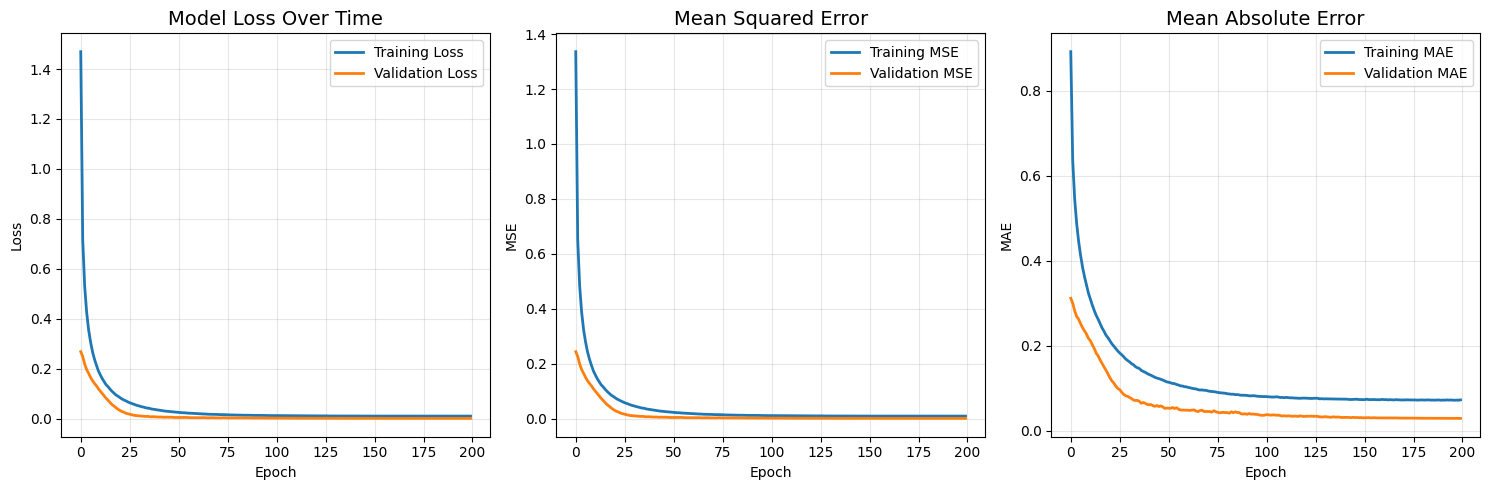

In [17]:
print("\n=== Training Results Visualization ===")

plt.figure(figsize=(15, 5))

# Plot training history
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['mse'], label='Training MSE', linewidth=2)
plt.plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
plt.title('Mean Squared Error', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Mean Absolute Error', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
print("\n=== Reconstruction Error Analysis ===")

def calculate_reconstruction_error(model, data, batch_size=1024):
    """Calculate reconstruction errors efficiently"""
    predictions = model.predict(data, batch_size=batch_size, verbose=0)
    errors = np.mean(np.square(data - predictions), axis=1)
    return errors



=== Reconstruction Error Analysis ===


In [19]:
print("Calculating reconstruction errors...")
train_errors = calculate_reconstruction_error(autoencoder, X_train_normal)
val_errors = calculate_reconstruction_error(autoencoder, X_val_normal)
anomaly_errors = calculate_reconstruction_error(autoencoder, X_anomaly)

print(f"Training errors - Mean: {np.mean(train_errors):.6f}, Std: {np.std(train_errors):.6f}")
print(f"Validation errors - Mean: {np.mean(val_errors):.6f}, Std: {np.std(val_errors):.6f}")
print(f"Anomaly errors - Mean: {np.mean(anomaly_errors):.6f}, Std: {np.std(anomaly_errors):.6f}")

Calculating reconstruction errors...
Training errors - Mean: 0.001243, Std: 0.000372
Validation errors - Mean: 0.001435, Std: 0.000432
Anomaly errors - Mean: 0.008366, Std: 0.011034


In [20]:
print("\n=== Threshold Optimization ===")

# Calculate errors for the entire dataset
all_errors = calculate_reconstruction_error(autoencoder, X_processed)

# Try different threshold percentiles
thresholds = {}
percentiles = [90, 95, 97, 99, 99.5]

for p in percentiles:
    threshold = np.percentile(val_errors, p)
    predictions = (all_errors > threshold).astype(int)
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    
    thresholds[p] = {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions
    }
    
    print(f"Percentile {p}%: Threshold={threshold:.6f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


=== Threshold Optimization ===
Percentile 90%: Threshold=0.001987, Precision=0.081, Recall=0.430, F1=0.136
Percentile 95%: Threshold=0.002153, Precision=0.138, Recall=0.430, F1=0.209
Percentile 97%: Threshold=0.002311, Precision=0.208, Recall=0.420, F1=0.278
Percentile 99%: Threshold=0.002680, Precision=0.420, Recall=0.420, F1=0.420
Percentile 99.5%: Threshold=0.003049, Precision=0.600, Recall=0.420, F1=0.494


In [21]:
best_percentile = max(thresholds.keys(), key=lambda x: thresholds[x]['f1'])
best_threshold = thresholds[best_percentile]['threshold']
best_predictions = thresholds[best_percentile]['predictions']

print(f"\nBest threshold: {best_threshold:.6f} (at {best_percentile}th percentile)")


Best threshold: 0.003049 (at 99.5th percentile)


In [22]:
# ===== COMPREHENSIVE EVALUATION =====
print("\n=== Comprehensive Evaluation ===")

print("Classification Report:")
print(classification_report(y, best_predictions))

print("\nConfusion Matrix:")
cm = confusion_matrix(y, best_predictions)
print(cm)

# Calculate AUC-ROC
auc_score = roc_auc_score(y, all_errors)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# ===== VISUALIZATION =====
print("\n=== Advanced Visualizations ===")

plt.figure(figsize=(20, 12))


=== Comprehensive Evaluation ===
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9900
           1       0.60      0.42      0.49       100

    accuracy                           0.99     10000
   macro avg       0.80      0.71      0.74     10000
weighted avg       0.99      0.99      0.99     10000


Confusion Matrix:
[[9872   28]
 [  58   42]]

AUC-ROC Score: 0.7906

=== Advanced Visualizations ===


<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

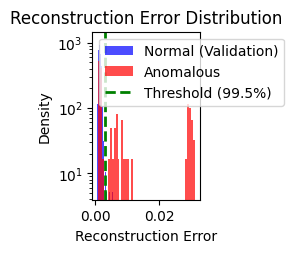

In [23]:
plt.subplot(2, 4, 1)
plt.hist(val_errors, bins=50, alpha=0.7, label='Normal (Validation)', density=True, color='blue')
plt.hist(anomaly_errors, bins=50, alpha=0.7, label='Anomalous', density=True, color='red')
plt.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold ({best_percentile}%)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.yscale('log')

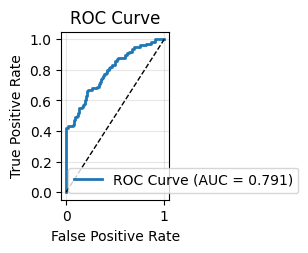

In [24]:
plt.subplot(2, 4, 2)
fpr, tpr, _ = roc_curve(y, all_errors)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)


Text(0.5, 225.12222222222223, 'Predicted Label')

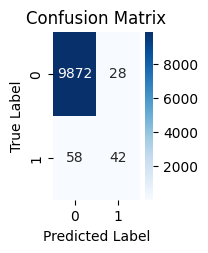

In [25]:
plt.subplot(2, 4, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

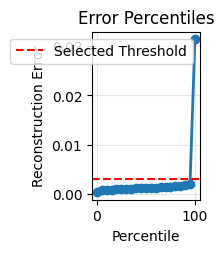

In [26]:
plt.subplot(2, 4, 4)
error_percentiles = [np.percentile(all_errors, p) for p in range(0, 101, 5)]
plt.plot(range(0, 101, 5), error_percentiles, marker='o', linewidth=2)
plt.axhline(best_threshold, color='red', linestyle='--', label='Selected Threshold')
plt.xlabel('Percentile')
plt.ylabel('Reconstruction Error')
plt.title('Error Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)

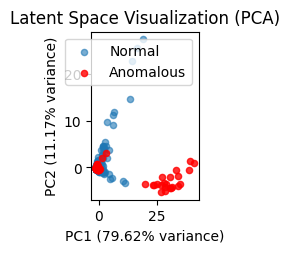

In [27]:
plt.subplot(2, 4, 5)
# Get latent representations
latent_normal = encoder.predict(X_val_normal[:1000], verbose=0)  # Sample for speed
latent_anomaly = encoder.predict(X_anomaly, verbose=0)

# Use PCA for 2D projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_combined = np.vstack([latent_normal, latent_anomaly])
latent_2d = pca.fit_transform(latent_combined)

normal_2d = latent_2d[:len(latent_normal)]
anomaly_2d = latent_2d[len(latent_normal):]

plt.scatter(normal_2d[:, 0], normal_2d[:, 1], alpha=0.6, label='Normal', s=20)
plt.scatter(anomaly_2d[:, 0], anomaly_2d[:, 1], alpha=0.8, label='Anomalous', s=20, color='red')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Latent Space Visualization (PCA)')
plt.legend()

Text(0.5, 1.0, 'Feature Reconstruction Difficulty')

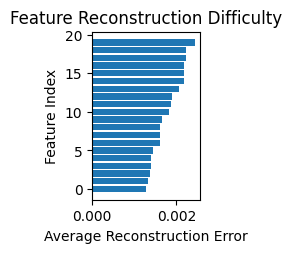

In [28]:
plt.subplot(2, 4, 6)
# Calculate feature-wise reconstruction errors
sample_data = X_val_normal[:100]  # Sample for analysis
reconstructed = autoencoder.predict(sample_data, verbose=0)
feature_errors = np.mean(np.square(sample_data - reconstructed), axis=0)

# Plot top 20 features
top_features = np.argsort(feature_errors)[-20:]
plt.barh(range(len(top_features)), feature_errors[top_features])
plt.xlabel('Average Reconstruction Error')
plt.ylabel('Feature Index')
plt.title('Feature Reconstruction Difficulty')

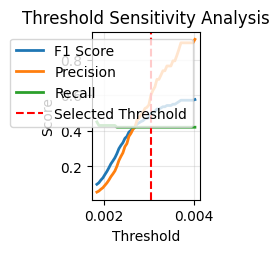

In [29]:
plt.subplot(2, 4, 7)
threshold_range = np.linspace(np.percentile(val_errors, 85), np.percentile(val_errors, 99.9), 50)
f1_scores = []
precisions = []
recalls = []

for thresh in threshold_range:
    pred = (all_errors > thresh).astype(int)
    f1_scores.append(f1_score(y, pred))
    precisions.append(precision_score(y, pred))
    recalls.append(recall_score(y, pred))

plt.plot(threshold_range, f1_scores, label='F1 Score', linewidth=2)
plt.plot(threshold_range, precisions, label='Precision', linewidth=2)
plt.plot(threshold_range, recalls, label='Recall', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label='Selected Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sensitivity Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

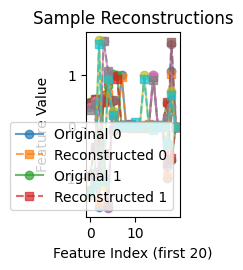

In [30]:
plt.subplot(2, 4, 8)
# Show reconstruction quality for a few samples
sample_indices = np.random.choice(len(X_val_normal), 5, replace=False)
original_samples = X_val_normal[sample_indices]
reconstructed_samples = autoencoder.predict(original_samples, verbose=0)

for i in range(5):
    plt.plot(original_samples[i][:20], 'o-', alpha=0.7, label=f'Original {i}' if i < 2 else "")
    plt.plot(reconstructed_samples[i][:20], 's--', alpha=0.7, label=f'Reconstructed {i}' if i < 2 else "")

plt.xlabel('Feature Index (first 20)')
plt.ylabel('Feature Value')
plt.title('Sample Reconstructions')
if len(original_samples[0]) > 0:
    plt.legend()

plt.tight_layout()
plt.show()

In [31]:
autoencoder.save('advanced_autoencoder_final.h5')
encoder.save('encoder_final.h5')

# Save preprocessing objects
import joblib
joblib.dump(scaler_num, 'scaler_numerical.pkl')
joblib.dump(best_threshold, 'best_threshold.pkl')

# Save results summary
results_summary = {
    'best_threshold': best_threshold,
    'best_percentile': best_percentile,
    'auc_score': auc_score,
    'final_metrics': thresholds[best_percentile],
    'model_architecture': {
        'input_dim': input_dim,
        'encoding_dims': [512, 256, 128, 64, 32],
        'total_parameters': autoencoder.count_params()
    }
}